In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import os
import time
import cv2
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten, GlobalMaxPooling2D, Dropout
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Dense, ReLU

In [3]:
data_path = '/content/drive/My Drive/transfer_learning_data/orthodontics/'
X_train = np.load(data_path+'train/X_train.npy').astype(float)
Y_train = np.load(data_path+'train/Y_train.npy').astype(float)
train_label=np.load(data_path+'train/data_label.npy').astype(float)
train_input=np.load(data_path+'train/data_input.npy').astype(float)
X_valid = np.load(data_path+'train/X_valid.npy').astype(float)
Y_valid = np.load(data_path+'train/Y_valid.npy').astype(float)
test_label = np.load(data_path+'test/data_label.npy').astype(float)
test_input = np.load(data_path+'test/data_input.npy').astype(float)

In [4]:
num_classes = 2
names = ['No', 'Yes']

In [5]:
print('Training Data: {}'.format(X_train.shape))
print('Test Data: {}'.format(X_valid.shape))

Training Data: (768, 224, 224, 3)
Test Data: (192, 224, 224, 3)


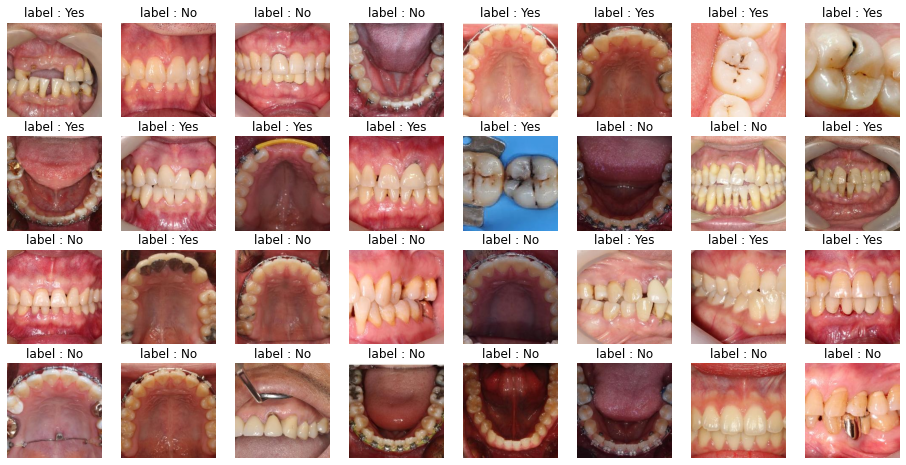

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
for k in range(32):
    img = X_train[k]
    label = Y_train[k]
    plt.subplot(4,8,1+k)
    plt.imshow((img).astype(np.uint8))
    plt.axis('off')
    plt.title('label : {0}'.format(names[int(label)]))
plt.show()

In [7]:
model = MobileNetV2(include_top=True, weights='imagenet')
model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________

In [8]:
x = Dense(1, activation='sigmoid', name='predictions')(model.layers[-2].output)
custom_mobilenetv2_model = Model(model.input, x)

for layer in custom_mobilenetv2_model.layers[:-1]:
	layer.trainable = False

custom_mobilenetv2_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

custom_mobilenetv2_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [9]:
X_train_resize = list()
for i in range(len(X_train)):
  X_train_resize.append(cv2.resize(X_train[i], dsize = (244, 244)))
X_train_resize = np.array(X_train_resize)

X_valid_resize = list()
for i in range(len(X_valid)):
  X_valid_resize.append(cv2.resize(X_valid[i], dsize = (244, 244)))
X_valid_resize = np.array(X_valid_resize)

test_input_resize = list()
for i in range(len(test_input)):
  test_input_resize.append(cv2.resize(test_input[i], dsize = (244, 244)))
test_input_resize = np.array(test_input_resize)

In [10]:
n_epochs = 50
n_batch = 32

In [11]:
t=time.time()
hist = custom_mobilenetv2_model.fit(X_train_resize, Y_train, batch_size=n_batch, epochs=n_epochs, verbose=1, validation_data=(X_valid_resize, Y_valid))
print('Training time: %s' % (t - time.time()))

Epoch 1/50
24/24 [==============================] - 2s 92ms/step - loss: 0.8529 - accuracy: 0.5182 - val_loss: 0.6808 - val_accuracy: 0.5469
Epoch 2/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6694 - accuracy: 0.5859 - val_loss: 0.6876 - val_accuracy: 0.5156
Epoch 3/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6426 - accuracy: 0.5990 - val_loss: 0.6438 - val_accuracy: 0.5677
Epoch 4/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6266 - accuracy: 0.6458 - val_loss: 0.6336 - val_accuracy: 0.5781
Epoch 5/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6147 - accuracy: 0.6445 - val_loss: 0.6293 - val_accuracy: 0.6042
Epoch 6/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6040 - accuracy: 0.6745 - val_loss: 0.6339 - val_accuracy: 0.6250
Epoch 7/50
24/24 [==============================] - 1s 60ms/step - loss: 0.6004 - accuracy: 0.6549 - val_loss: 0.6205 - val_accuracy: 0.5677
Epoch 8/50
24

In [12]:
(loss, accuracy) = custom_mobilenetv2_model.evaluate(test_input_resize, test_label, batch_size=n_batch, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

4/4 [==============================] - 0s 70ms/step - loss: 0.5853 - accuracy: 0.6900
[INFO] loss=0.5853, accuracy: 69.0000%


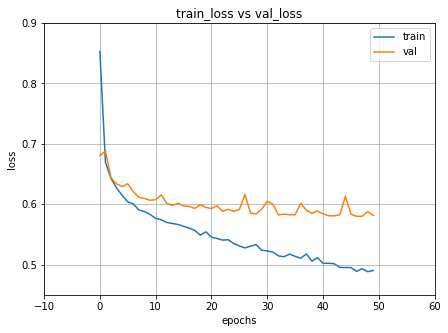

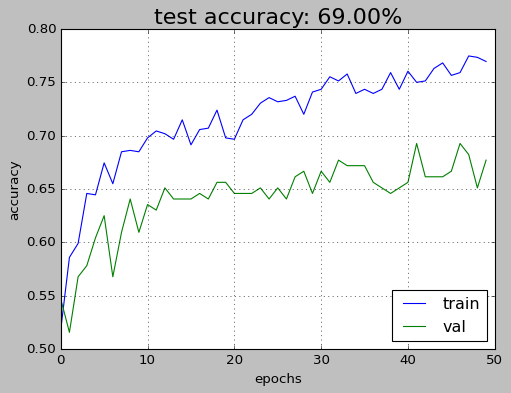

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(len(train_loss))

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('test accuracy: {:.2f}%'.format(accuracy*100), fontsize=20)
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.show()